In [1]:
## Machine Learning - Breast Tumor Classification Project

In [2]:
# EDA
# split data as test and train
# scaling (X_train,X_test) for KNN and Logistic R.
# cross-validation
# modelling
# model evaluation

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import LinearSVC, SVC
from joblib import dump, load
import shap

In [5]:
import psycopg2

In [6]:
# Connecting Postgresql Server

In [7]:
param = {
    'host':'localhost',
    'user':'postgres',
    'port':5432,
    'password':'R*******'
}
connection = psycopg2.connect(**param, dbname='database_ds')

In [8]:
df = pd.read_sql('select * from schema_ds.breast_cancer ', connection)

In [9]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [6,4], fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [6,4].
    fontsize: int
        Font size for axes labels. Defaults to 12.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [10]:
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = ["Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [11]:
# Reading from csv file

In [12]:
# df = pd.read_csv('breast-cancer.csv')
# source kaggle 
# (www.kaggle.com/datasets/yasserh/breast-cancer-dataset)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [14]:
df.isnull().sum() # null values

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [15]:
df.duplicated().sum() # duplicate values

0

In [16]:
df.drop(['id'], axis=1 , inplace=True)

In [17]:
df.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [18]:
df['diagnosis'].value_counts(normalize=True) # ratios as percentages

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [19]:
df['diagnosis']

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [20]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [21]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [22]:
df['target']=df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

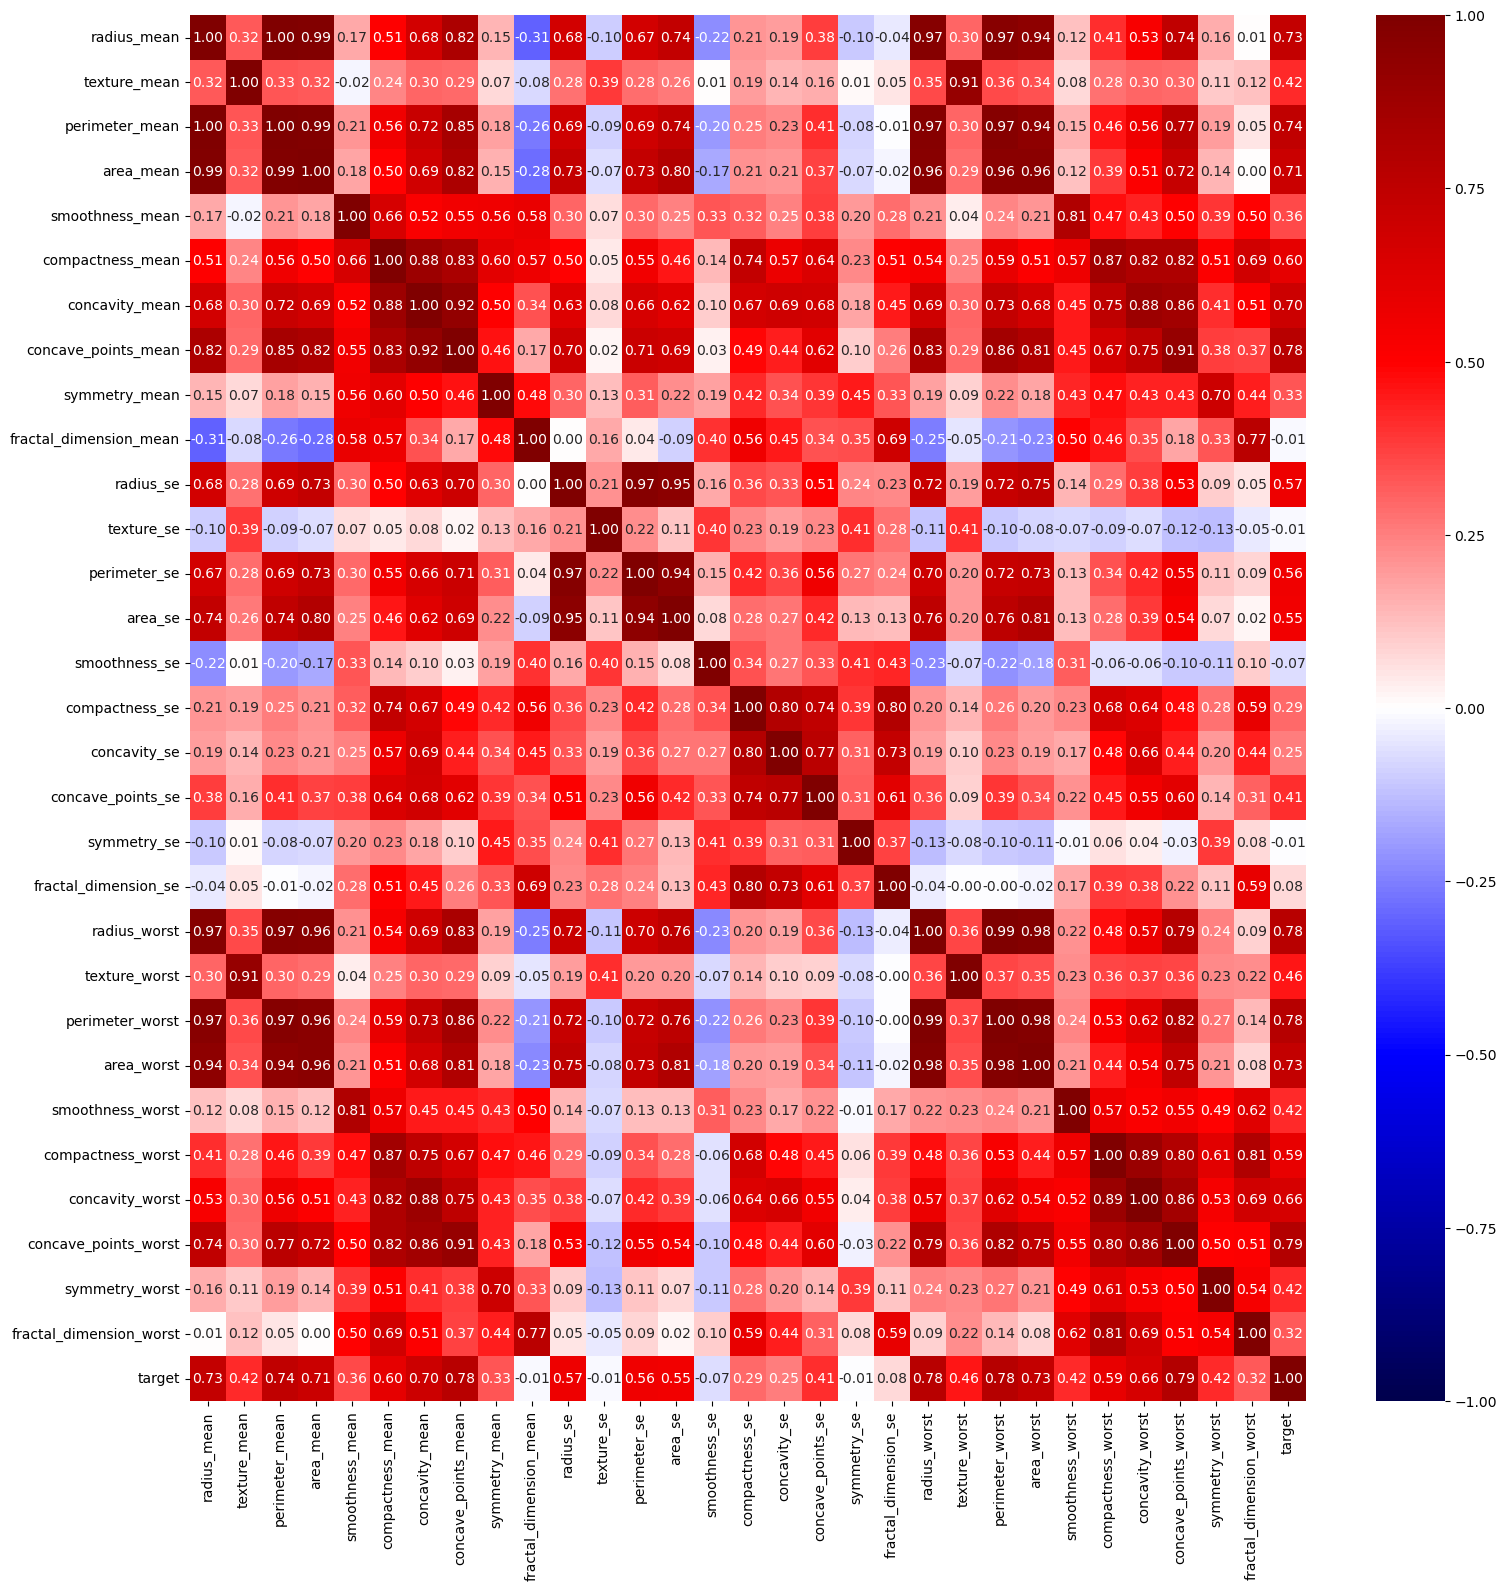

In [23]:
plt.figure(figsize=[18,18])
sns.heatmap(df.corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

In [24]:
# Dropping the columns that exhibit multicollinearity among them

In [26]:
new_df = df.drop(['perimeter_mean','area_mean','perimeter_se','area_se',
                  'radius_mean','perimeter_worst', 'area_worst'], axis=1)


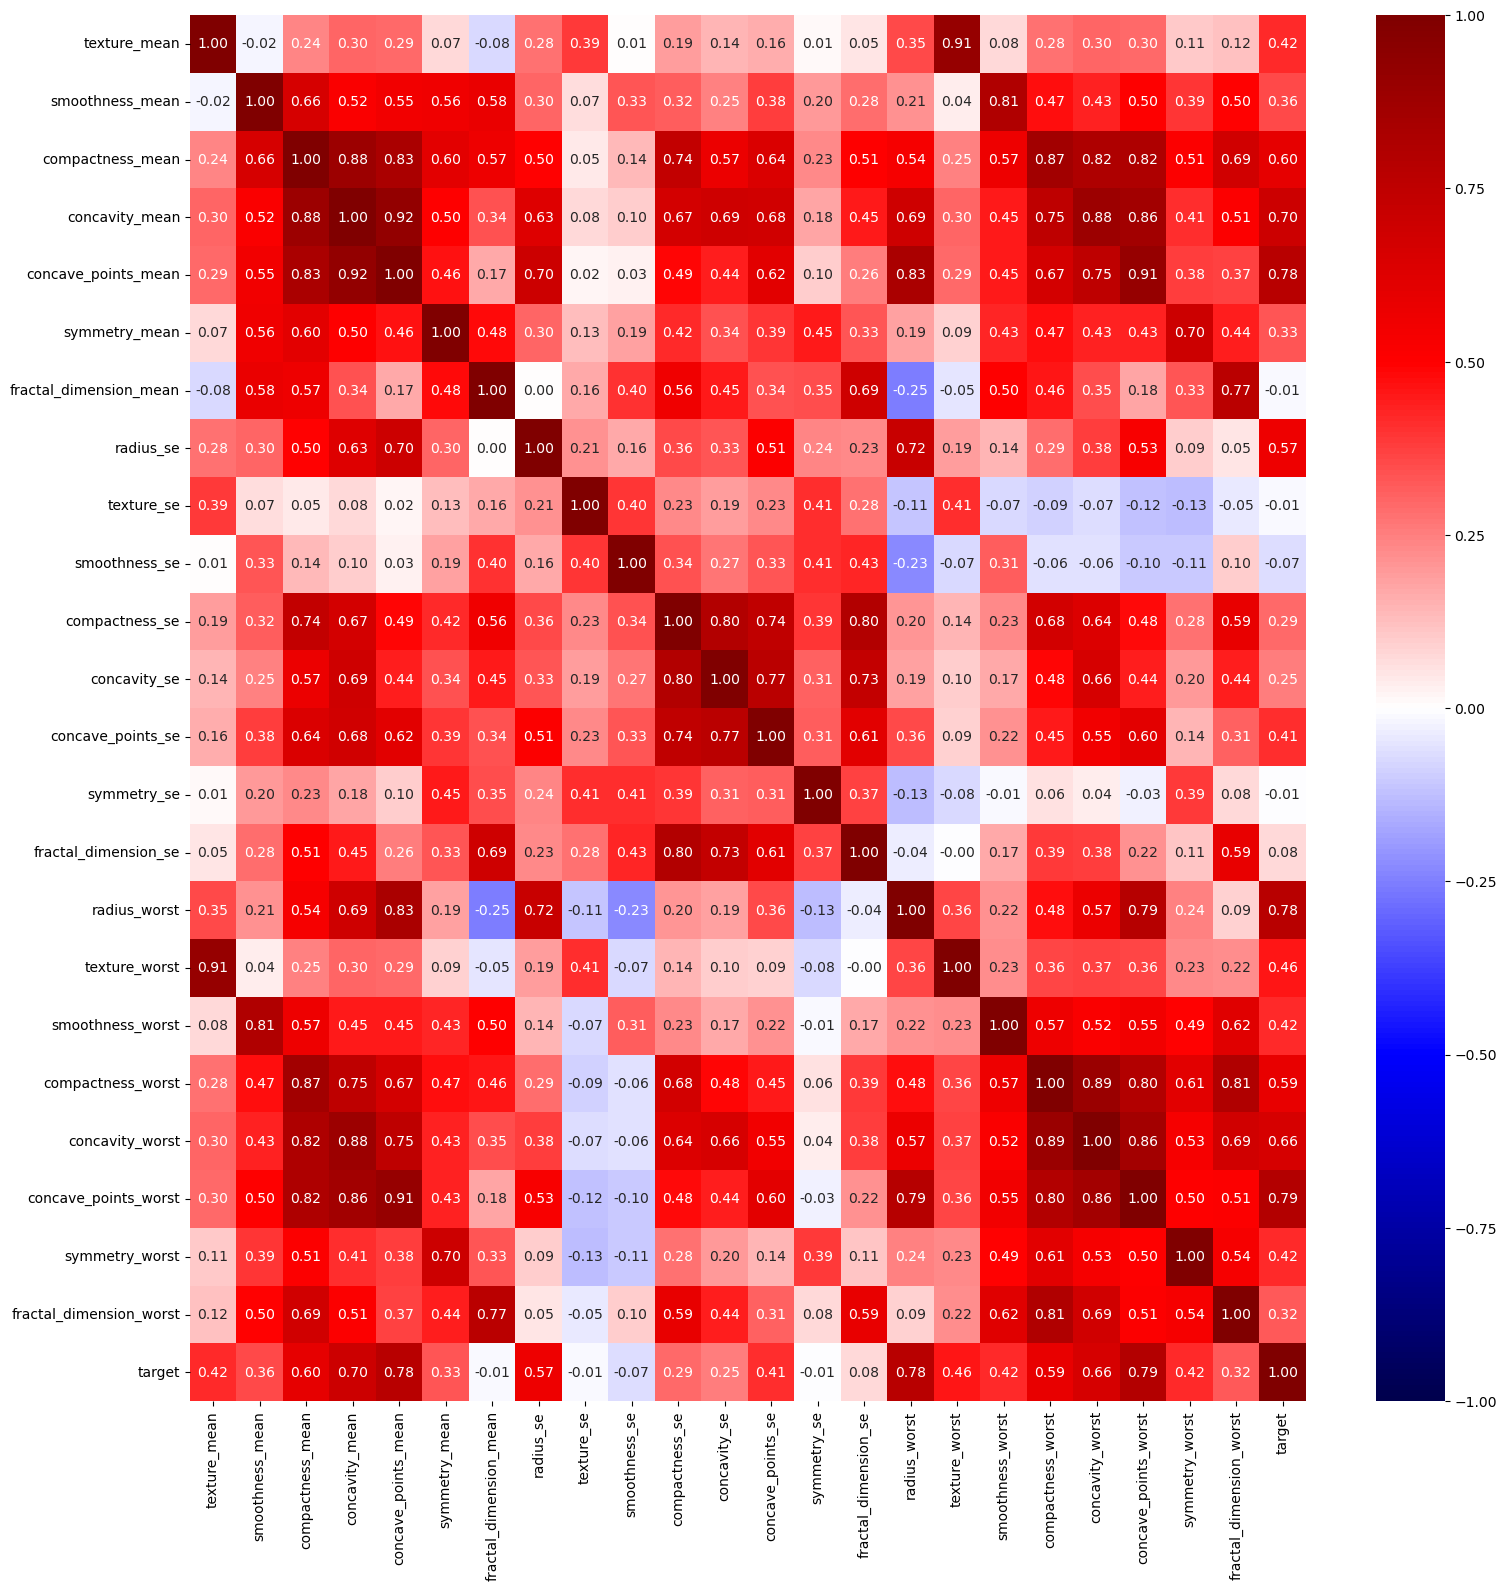

In [27]:
plt.figure(figsize=[18,18])
sns.heatmap(new_df.corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

In [28]:
# Defining features(X) and target(y)

In [29]:
X = new_df.drop(columns=['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

print(X.shape)
print(y.shape)

(569, 23)
(569,)


In [ ]:
sns.pairplot(new_df, hue='diagnosis');

In [30]:
# Spliting data into train and test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                test_size = 0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(455, 23)
(114, 23)
(455,)
(114,)


In [32]:
# Implementing Scaling

In [33]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train) # fit_transform for train
X_test_scaled = std_scale.transform(X_test) # transform fot test

In [34]:
# Logistic Regression

In [35]:
score = []
logr = LogisticRegression(solver='liblinear')
logr.fit(X_train_scaled, y_train)

score = cross_val_score(estimator=logr, X=X_train_scaled, y=y_train, 
                        scoring='accuracy', cv=5)
print('Logistic Regression CV Scores:',np.round(score,3))
print('Logistic Regression Mean Score:',round(score.mean(),3) )

Logistic Regression CV Scores: [0.989 0.967 1.    0.978 0.956]
Logistic Regression Mean Score: 0.978


In [36]:
print("Logistic Regression Testing Accuracy:", 
      round(logr.score(X_test_scaled, y_test),3))

Logistic Regression Testing Accuracy: 0.974


In [37]:
print('Logistic Regression Confusion Matrix: \n\n', 
      confusion_matrix(y_test, logr.predict(X_test_scaled)))

Logistic Regression Confusion Matrix: 

 [[69  2]
 [ 1 42]]


In [40]:
print('Logistic Reggression')
evaluate_model(logr, X_test_scaled, y_test, pred_label=1) # "M"=1

Logistic Reggression


,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.974,0.977,0.955,0.966,0.974


In [41]:
evaluate_model(logr, X_test_scaled, y_test, pred_label=0) # "B"=0

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.974,0.972,0.986,0.979,0.974


In [38]:
print("Log-Loss on LogReg: {:6.3f}".format(log_loss(y_test, logr.predict_proba(X_test_scaled))))

Log-Loss on LogReg:  0.069


In [39]:
np.set_printoptions(suppress=True, precision= 2)
logr.predict_proba(X_test_scaled)

array([[0.82, 0.18],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.09, 0.91],
       [0.35, 0.65],
       [1.  , 0.  ],
       [0.93, 0.07],
       [0.02, 0.98],
       [0.99, 0.01],
       [0.23, 0.77],
       [1.  , 0.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.88, 0.12],
       [0.98, 0.02],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.12, 0.88],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.95, 0.05],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.94, 0.06],
       [0.91, 0.09],
       [1.  , 0.  ],
       [1.  ,

In [42]:
def make_confusion_matrix(model, threshold=0.5): # Ön tanımlı threshold değeri
    
    y_predict = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    tumor_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=80)
    sns.heatmap(tumor_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['B', 'M'],
           yticklabels=['B', 'M']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

In [43]:
# Threshold değerini değiştirdiğimizde sonucun da interaktif bir şekilde değişmesi için bir widget

from ipywidgets import interactive

interactive(lambda threshold: make_confusion_matrix(logr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [44]:
# 0.12 threshold değerine göre sınıflandırma
new_threshold = 0.12
y_predict = (logr.predict_proba(X_test_scaled)[:,1] > new_threshold)
print('New Threshold:', new_threshold)
print('Precision: {:6.3f},\n   Recall: {:6.3f}, \n Accuracy: {:6.3f}'.format(precision_score(y_test, y_predict), recall_score(y_test, y_predict),accuracy_score(y_test, y_predict)))

New Threshold: 0.12
Precision:  0.857,
   Recall:  0.977, 
 Accuracy:  0.930


In [45]:
np.set_printoptions(suppress=True, precision= 2)
logr.predict_proba(X_test_scaled)

array([[0.82, 0.18],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.09, 0.91],
       [0.35, 0.65],
       [1.  , 0.  ],
       [0.93, 0.07],
       [0.02, 0.98],
       [0.99, 0.01],
       [0.23, 0.77],
       [1.  , 0.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.88, 0.12],
       [0.98, 0.02],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.12, 0.88],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.95, 0.05],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.94, 0.06],
       [0.91, 0.09],
       [1.  , 0.  ],
       [1.  ,

In [46]:
importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.abs(np.round(logr.coef_.reshape(23,),3))})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances.head(23)

,Importance
Feature,
radius_worst,2.121
radius_se,2.105
concave_points_mean,1.533
symmetry_worst,1.194
texture_worst,1.170
concavity_mean,0.996
concavity_worst,0.909
concave_points_worst,0.818
symmetry_se,0.597


In [47]:
# K-Nearest Neighbors(KNN)

In [48]:
knn = KNeighborsClassifier()

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'minkowski']
param_grid = dict(n_neighbors=k_range, weights=weight_options, 
                  metric=metric_options)

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)
print("Best Score: ",round(grid.best_score_,3))
print("Best Parameters:",grid.best_params_)

Best Score:  0.96
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


In [49]:
knn_scores = []

knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, 
                           weights = 'uniform')
knn_scores = cross_val_score(estimator=knn, X=X_train_scaled, 
                             y=y_train, scoring='accuracy', cv=5)
print('KNN CV Scores: ', knn_scores)
print('KNN Mean Score:', round(knn_scores.mean(),3) )

KNN CV Scores:  [0.93 0.93 0.99 0.97 0.93]
KNN Mean Score: 0.952


In [50]:
knn.fit(X_train_scaled, y_train)
print('KNN Confusion Matrix: \n\n', confusion_matrix(y_test, 
                                                     knn.predict(X_test_scaled)))

KNN Confusion Matrix: 

 [[68  3]
 [ 5 38]]


In [51]:
print("KNN Testing Accuracy:", 
      round(knn.score(X_test_scaled, y_test),3))

KNN Testing Accuracy: 0.93


In [54]:
evaluate_model(knn, X_test_scaled, y_test, pred_label=1) # "M"=1

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.93,0.884,0.927,0.905,0.921


In [55]:
evaluate_model(knn, X_test_scaled, y_test, pred_label=0) # "B"=0

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.93,0.958,0.932,0.944,0.921


In [52]:
knn.predict_proba(X_test_scaled)

array([[1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.67, 0.33],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.67, 0.33],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.67, 0.33],
       [0.67, 0.33],
       [1.  , 0.  ],
       [1.  ,

In [53]:
print("Log-Loss on KNN: {:6.3f}".format(log_loss(y_test, knn.predict_proba(X_test_scaled))))

Log-Loss on KNN:  1.025


In [ ]:
# Decision Tree

In [56]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

results = cross_val_score(dt_model, X_train, y_train, cv=5)
print("Decision Tree CV Accuracy Scores: ", np.round(results,3))
print("Decision Tree CV Accuracy Mean: ", np.round(results.mean(),3))

Decision Tree CV Accuracy Scores:  [0.9  0.91 0.92 0.92 0.93]
Decision Tree CV Accuracy Mean:  0.919


In [57]:
y_pred_dt = dt_model.predict(X_test)
confusion_matrix(y_test, y_pred_dt)

array([[67,  4],
       [ 4, 39]])

In [59]:
print("Decision Tree Testing Accuracy:", 
      round(dt_model.score(X_test, y_test),3))

Decision Tree Testing Accuracy: 0.93


In [60]:
evaluate_model(dt_model, X_test, y_test, pred_label=1) # "M"=1

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.93,0.907,0.907,0.907,0.925


In [61]:
evaluate_model(dt_model, X_test, y_test, pred_label=0) # "B"=0

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.93,0.944,0.944,0.944,0.925


In [62]:
import numpy as np
importances_dt = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(dt_model.feature_importances_,3)})
importances_dt = importances_dt.sort_values('Importance', ascending=False).set_index('Feature')
importances_dt

,Importance
Feature,
concave_points_mean,0.691
radius_worst,0.081
concave_points_worst,0.066
texture_worst,0.055
texture_mean,0.028
fractal_dimension_se,0.019
concave_points_se,0.016
radius_se,0.012
smoothness_worst,0.009


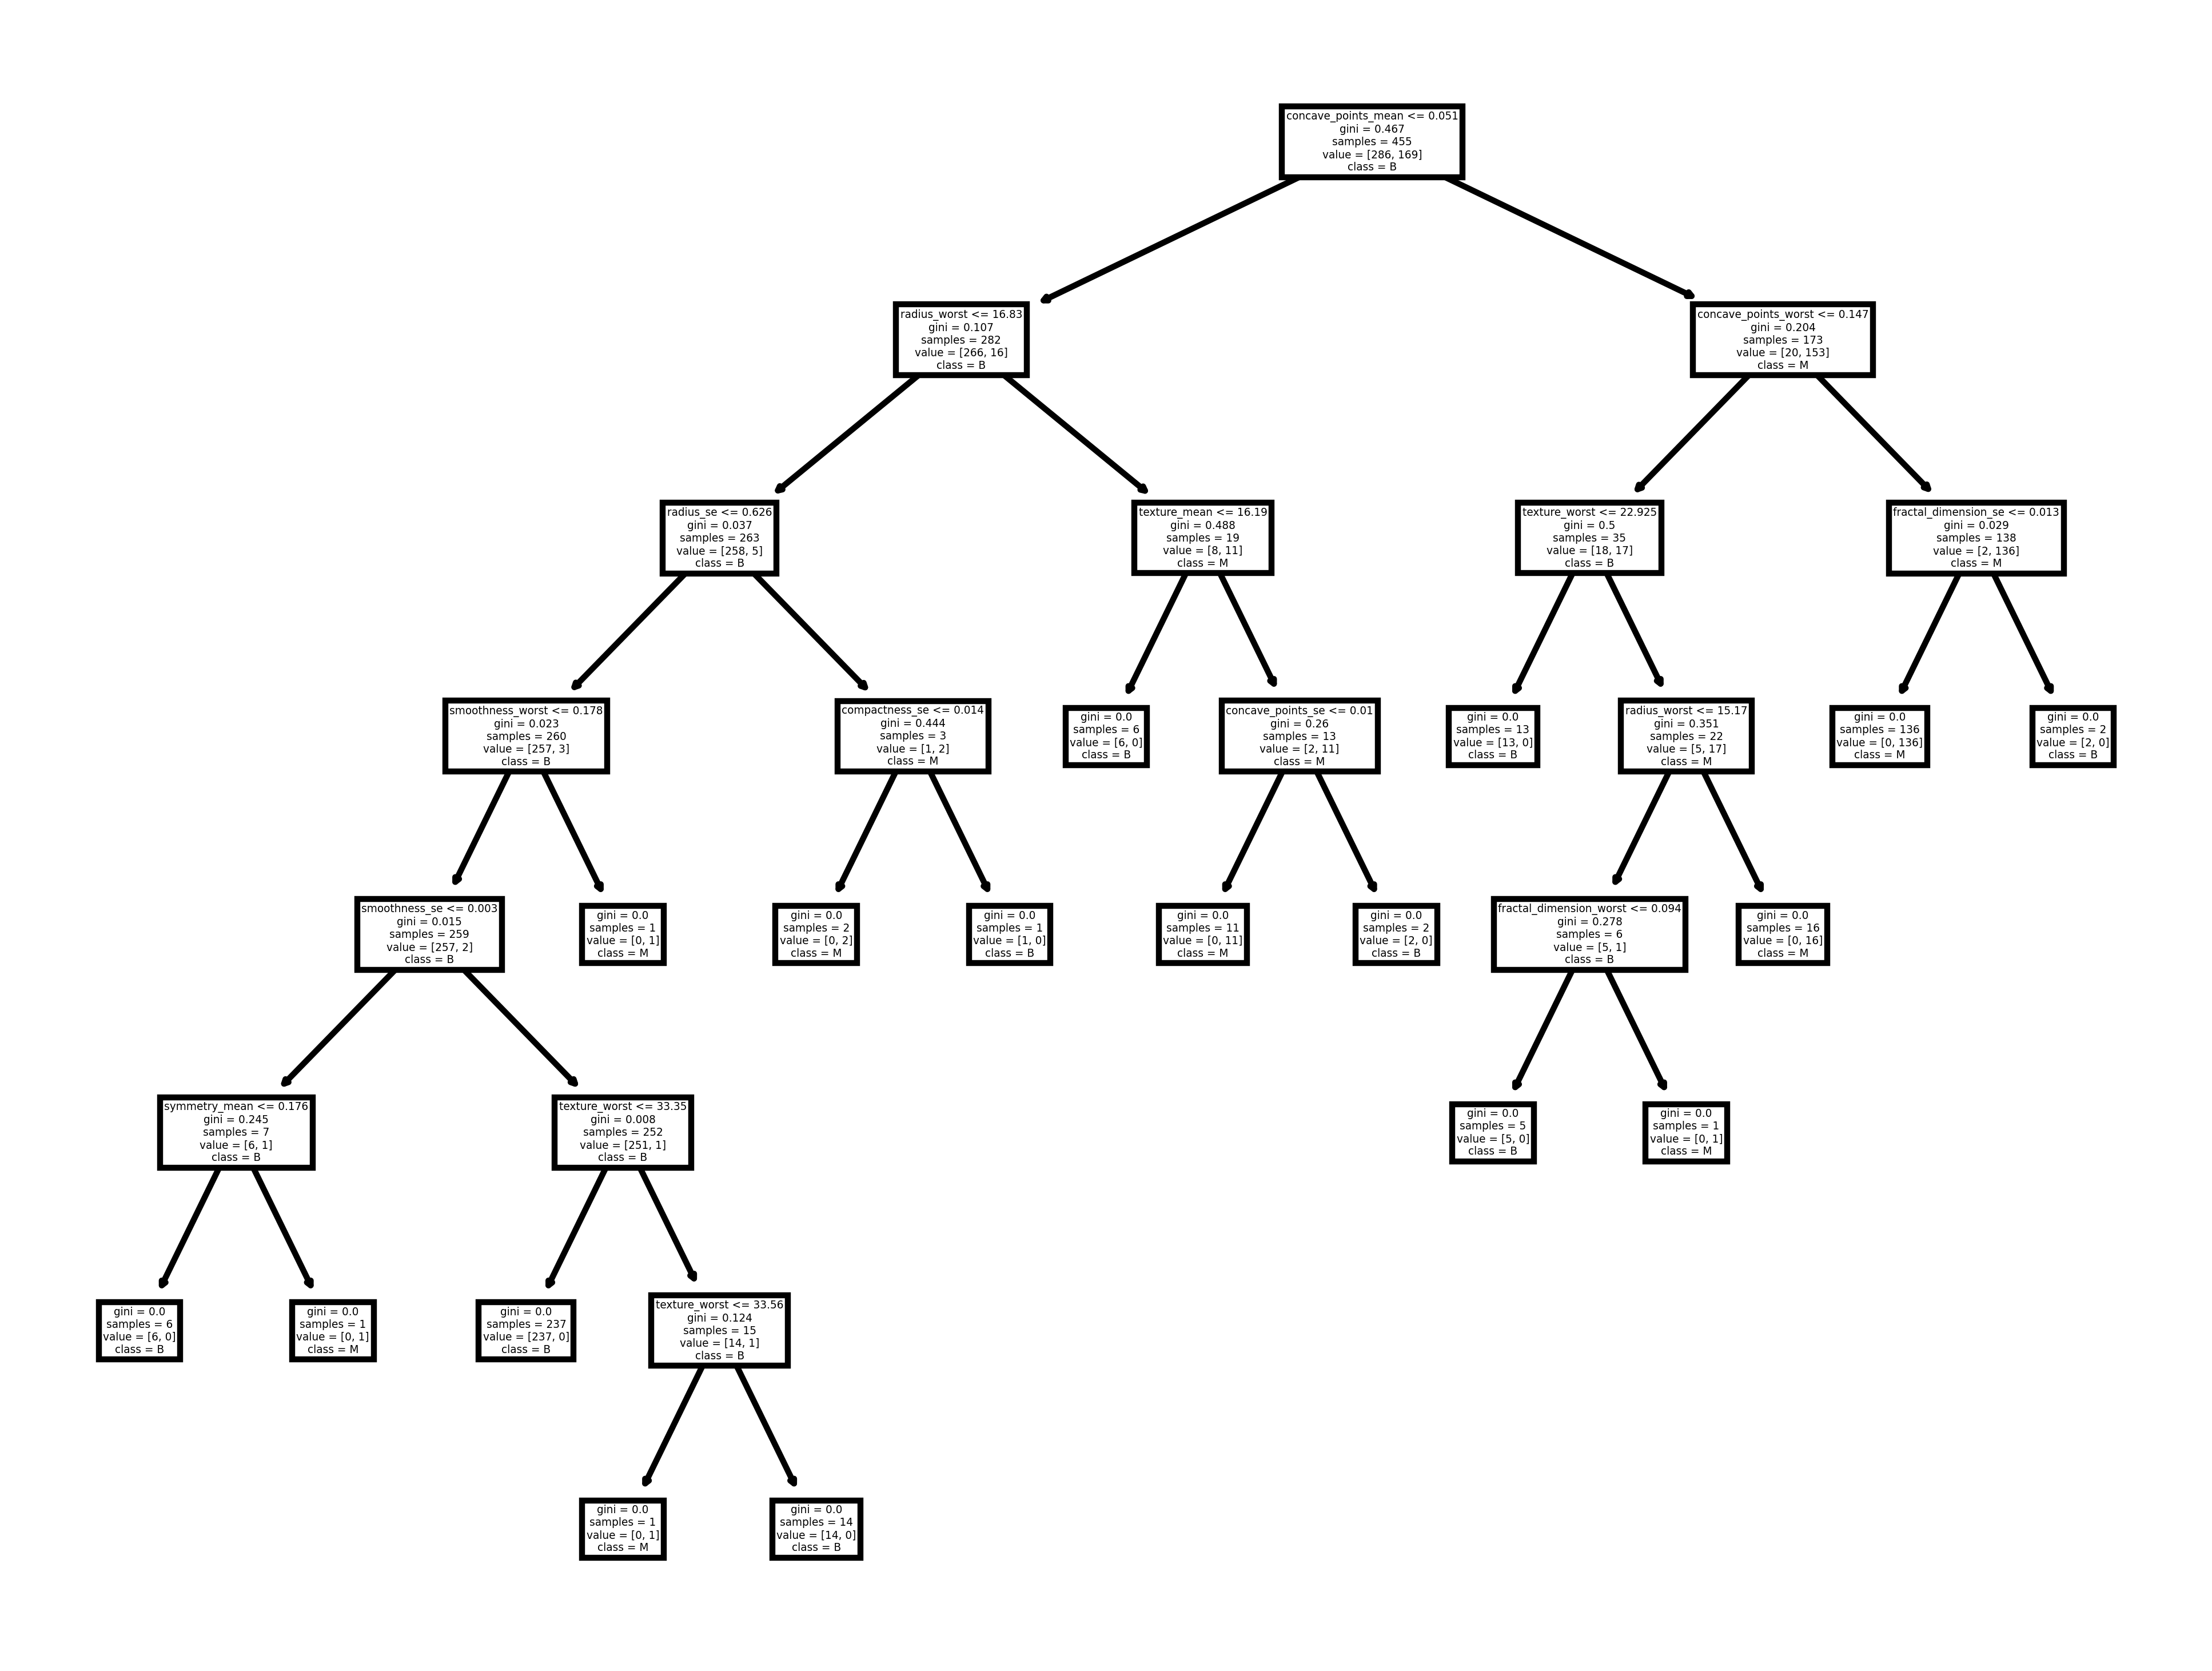

In [63]:
plt.figure(dpi=750)
plot_tree(dt_model, feature_names=X.columns, class_names=['B','M']);

In [ ]:
# Random Forest

In [64]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, 
                                                    random_state=42)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [65]:
results = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Random Forest CV Accuracy Scores: ", np.round(results,3))
print("Random Forest CV Accuracy Mean: ", np.round(results.mean(),3))

Random Forest CV Accuracy Scores:  [0.97 0.94 0.98 0.97 0.94]
Random Forest CV Accuracy Mean:  0.96


In [66]:
y_pred_rf = rf_model.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

array([[70,  1],
       [ 3, 40]])

In [67]:
evaluate_model(rf_model, X_test, y_test, pred_label=1) # "M"=1

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.965,0.93,0.976,0.952,0.958


In [68]:
evaluate_model(rf_model, X_test, y_test, pred_label=0) # "B"=0

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.965,0.986,0.959,0.972,0.958


In [69]:
importances_rf = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_rf = importances_rf.sort_values('Importance', ascending=False).set_index('Feature')
importances_rf

,Importance
Feature,
concave_points_mean,0.225
radius_worst,0.145
concave_points_worst,0.142
concavity_mean,0.096
concavity_worst,0.059
radius_se,0.045
compactness_worst,0.041
compactness_mean,0.037
texture_worst,0.033


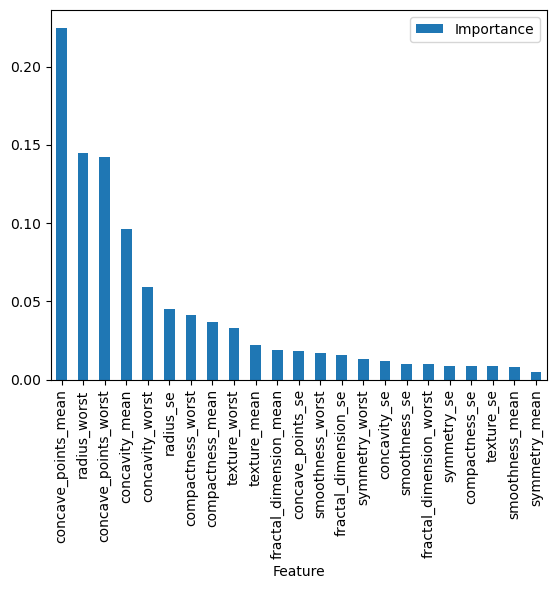

In [70]:
importances_rf.plot.bar();

In [71]:
# Xgboost

In [72]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values_classification = explainer(X_test)

In [73]:
results = cross_val_score(xgb_model, X_train, y_train, cv=5)
print("Xgboost CV Accuracy Scores: ", np.round(results,3))
print("Xgboost CV Accuracy Mean: ", np.round(results.mean(),3))

Xgboost CV Accuracy Scores:  [0.97 0.97 0.99 0.97 0.94]
Xgboost CV Accuracy Mean:  0.967


In [74]:
y_pred = xgb_model.predict(X_test)

predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("XGBoost Test Accuracy: ", round(accuracy,2))

XGBoost Test Accuracy:  0.96


In [75]:
print('Xgboost Test Accuracy:')
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Xgboost Test Accuracy:
[[69  2]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [76]:
shap.initjs()

In [77]:
X_test.join(y_test)

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,...,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
204,18.60,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373,0.3961,1.0440,0.006953,...,0.003586,14.97,24.64,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750,0
70,21.31,0.09009,0.10290,0.10800,0.07951,0.1582,0.05461,0.7888,0.7975,0.004444,...,0.001698,24.86,26.58,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589,1
131,19.48,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,0.006240,...,0.002461,19.26,26.00,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019,1
431,17.68,0.10540,0.13160,0.07741,0.02799,0.1811,0.07102,0.1767,1.4600,0.010000,...,0.006005,12.88,22.91,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359,0
540,14.44,0.09984,0.11200,0.06737,0.02594,0.1818,0.06782,0.2784,1.7680,0.012150,...,0.005512,12.26,19.68,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,16.85,0.08641,0.06698,0.05192,0.02791,0.1409,0.05355,0.2204,1.0060,0.003535,...,0.001219,16.46,25.44,0.1142,0.2070,0.2437,0.07828,0.2455,0.06596,0
75,19.65,0.09168,0.08424,0.09769,0.06638,0.1798,0.05391,0.7474,1.0160,0.010820,...,0.001948,19.77,24.56,0.1500,0.2045,0.2829,0.15200,0.2650,0.06387,1
249,14.93,0.10130,0.07808,0.04328,0.02929,0.1883,0.06168,0.2562,1.0380,0.006662,...,0.002784,12.65,21.19,0.1389,0.1582,0.1804,0.09608,0.2664,0.07809,0
238,27.85,0.08223,0.10390,0.11030,0.04408,0.1342,0.06129,0.3354,2.3240,0.006307,...,0.003589,15.75,40.54,0.1081,0.2426,0.3064,0.08219,0.1890,0.07796,0


In [78]:
# Using Shap explainer

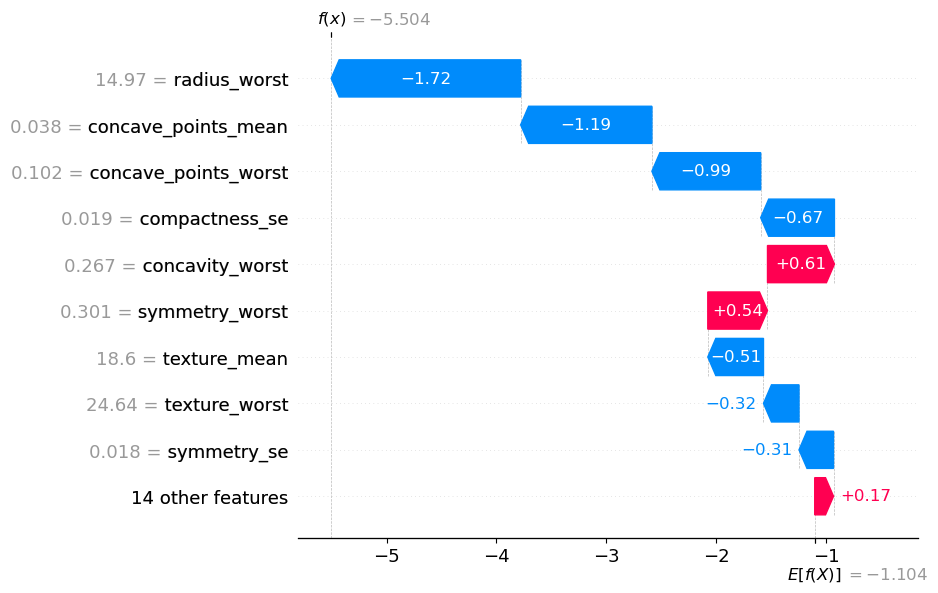

In [79]:
shap.plots.waterfall(shap_values_classification[0])

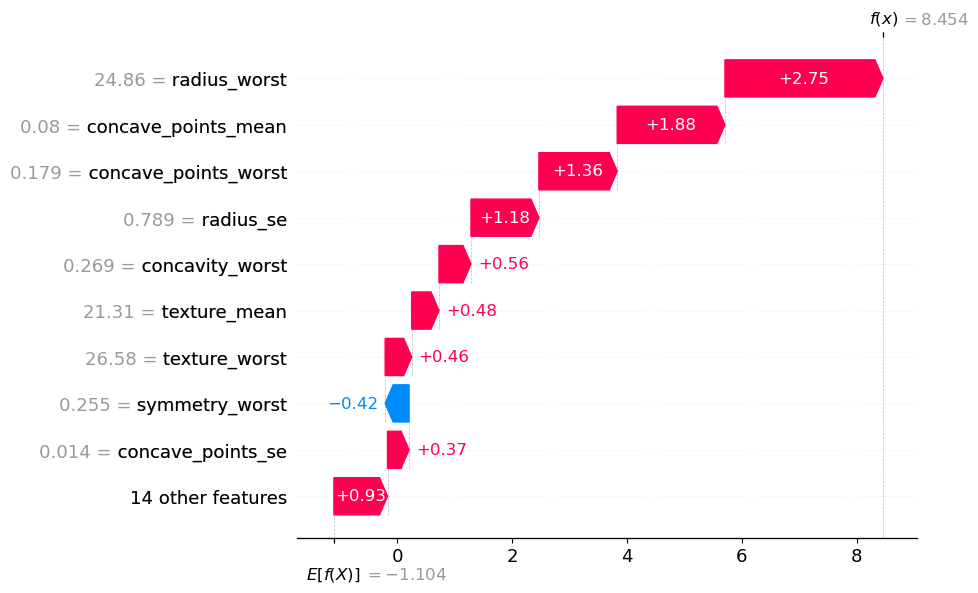

In [80]:
shap.plots.waterfall(shap_values_classification[1])

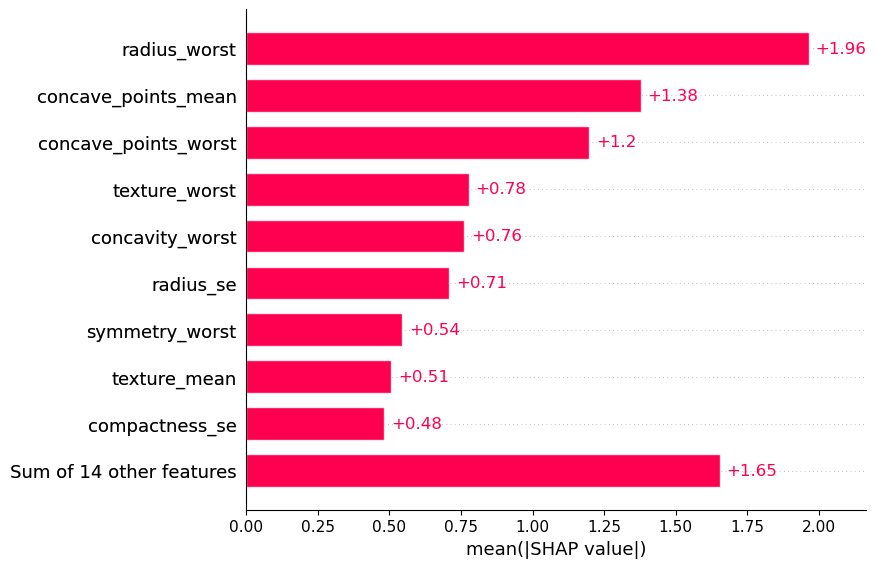

In [81]:
shap.plots.bar(shap_values_classification)

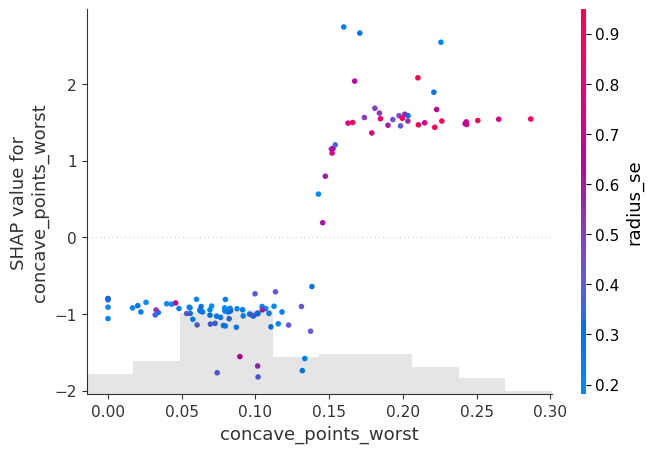

In [82]:
shap.plots.scatter(shap_values_classification[:, "concave_points_worst"], color=shap_values_classification[:, "radius_se"])

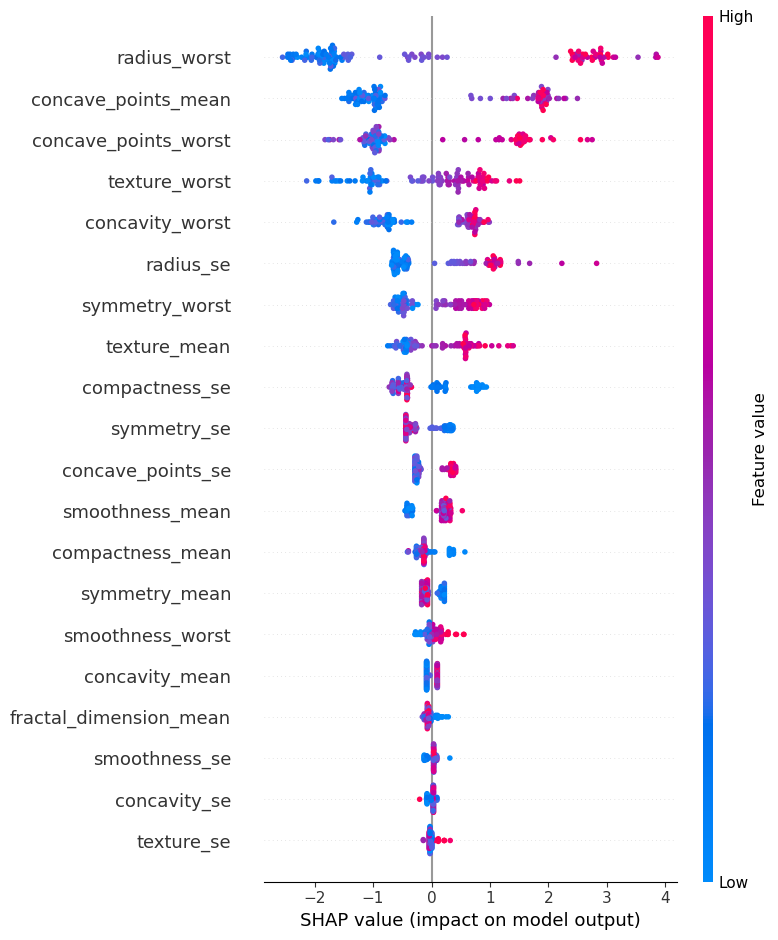

In [83]:
shap.summary_plot(shap_values_classification, X_test, )

In [ ]:
# Support Vector Classifier (SVC) 

In [84]:
X = new_df.drop(['diagnosis','target'], axis=1)
y = new_df['diagnosis'].apply(lambda x:1 if x=='M' else 0) # M=1 , B=0

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2,random_state=42, stratify=y)

svc = SVC().fit(X_train, y_train)

results = cross_val_score(svc, X_train, y_train, cv=5)
print("SVC CV Accuracy Scores: ", np.round(results,3))
print("SVC CV Accuracy Mean: ", np.round(results.mean(),3))

SVC CV Accuracy Scores:  [0.91 0.96 0.9  0.93 0.91]
SVC CV Accuracy Mean:  0.923


In [85]:
y_pred_svc = svc.predict(X_test)
confusion_matrix(y_test, y_pred_svc)

array([[71,  1],
       [11, 31]])

In [98]:
print("SVC Testing Accuracy:", 
      round(svc.score(X_test, y_test),3))

SVC Testing Accuracy: 0.895


In [87]:
evaluate_model(svc, X_test, y_test, pred_label=1) # "M"=1

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.895,0.738,0.969,0.838,0.862


In [ ]:
# Saving the best models as a pickle file

In [ ]:
dump(knn, 'knn_model.pkl')

In [ ]:
dump(xgb_model, 'xgb_model.pkl')

In [ ]:
#  results

In [94]:
data={'model':['LinearRegression','K-NN','DecisionTree','RandomForest','XGBoost','SVC'],
        'score':[0.974,0.93,0.93, 0.965,0.96,0.895] 
     }

In [95]:
model_df = pd.DataFrame(data)

In [96]:
import plotly.express as px

model_df.sort_values('score',inplace=True,ascending=False)
fig = px.bar(model_df, x="model", y="score", title="Models and Scores", text_auto=True, color="score")
fig.show()
